In [147]:
import Pkg; Pkg.add("JLD2")
using CSV, Tables, LinearAlgebra, Random, Gurobi, JuMP, Statistics, DataFrames, JLD2

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


## Import files

In [148]:
# Station information
stations_info = CSV.read("../data/stations/station_information.csv", DataFrame);
# Capacities
C = stations_info[!, :capacity];
# Distances
D = load("../data/parameters/distances.jld2", "D");
# Feasibility
X = load("../data/parameters/feasibility.jld2", "X");
# demand
demand = load("../data/parameters/202210-demand.jld2", "demand");

## Input parameters

In [254]:
# Initial state 
y0 = floor.(C/2);
# demand over one day
# Day 1
d = demand[:,:,1:24];
# Day 8
d_2 = demand[:,:,169:192];
# Day 15
d_3 = demand[:,:,337:360];

## Problem size reduction

In [255]:
function reduce_problem(d,C,y0,D,X,nb)
    n_stations = size(d,1)
    stations_score = zeros(n_stations)
    # for each station i, sum the number of bikes that gets in an out ot the station over the month
    for i in 1:n_stations
        stations_score[i] += sum(d[i,:,:]) + sum(d[:,i,:])
    end
    # sort stations by score
    stations_score_sorted = sortperm(stations_score, rev=true);
    # reorder index of columns and rows according to the sorted stations
    d_sorted = d[stations_score_sorted, stations_score_sorted, :];
    C_sorted = C[stations_score_sorted,:];
    y0_sorted = y0[stations_score_sorted,:];
    D_sorted = D[stations_score_sorted, stations_score_sorted];
    X_sorted = X[stations_score_sorted, stations_score_sorted];
    # keep only the nb first stations
    d_new = d_sorted[1:nb,1:nb,:];
    C_new = C_sorted[1:nb,:];
    y0_new = y0_sorted[1:nb,:];
    D_new = D_sorted[1:nb,1:nb];
    X_new = X_sorted[1:nb,1:nb];
    return d_new, C_new, y0_new, D_new, X_new
end

reduce_problem (generic function with 1 method)

In [256]:
d_new, C_new, y0_new, D_new, X_new = reduce_problem(d,C,y0,D,X,200);
d_2_new, C_new, y0_new, D_new, X_new = reduce_problem(d_2,C,y0,D,X,200);
d_3_new, C_new, y0_new, D_new, X_new = reduce_problem(d_3,C,y0,D,X,200);

In [257]:
# check that it is the same
println(d[66,60,12]==d_new[2,1,12])

true


In [309]:
# compute difference between d_new and d_2_new
diff_12 = d_new - d_2_new;
diff_23 = d_2_new - d_3_new;
diff_13 = d_new - d_3_new;
# compute the sum difference over the day
diff_12_day=sum(diff_12,dims=3);
println(maximum(diff_12_day))
println(minimum(diff_12_day))
diff_23_day=sum(diff_23,dims=3);
println(maximum(diff_23_day))
println(minimum(diff_23_day))
diff_13_day=sum(diff_13,dims=3);
println(maximum(diff_13_day))
println(minimum(diff_13_day))

50
-38
38
-46
47
-63


# Model

In [258]:
function solve_model(K,S,C,D,X,y0,d, lambda, n_rebal)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "TimeLimit", 100)

    n_stations, _, n_hours = size(d)
    M=30

    # Decision variables
    @variable(model, x[1:n_rebal, 1:n_rebal, 1:K, 1:n_hours], Bin)
    @variable(model, 0 <= z[1:n_rebal, 1:n_rebal, 1:K, 1:n_hours], Int)
    @variable(model, 0 <= y[1:n_stations, 1:n_hours]) # Int by definition of the constraints
    @variable(model, 0 <= w[1:n_stations, 1:n_stations, 1:n_hours], Int)
    @variable(model, 0 <= u[1:n_stations, 1:n_stations, 1:n_hours])

    # Add constraints:
    # Stations capacity
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], y[i,t] <= C[i])
    # No rebalancing at the same station
    @constraint(model, [i in 1:n_rebal, k in 1:K, t in 1:n_hours], x[i,i,k,t] == 0)
    # Flow balance 
    @constraint(model, [i in 1:n_rebal, t in 2:n_hours], y[i,t] - y[i,t-1] == sum(w[j,i,t] for j in 1:n_stations)-sum(w[i,j,t] for j in 1:n_stations)-sum(z[i,j,k,t] for j in 1:n_rebal, k in 1:K)+sum(z[j,i,k,t] for j in 1:n_rebal, k in 1:K))
    @constraint(model, [i in n_rebal+1:n_stations, t in 2:n_hours], y[i,t] - y[i,t-1] == sum(w[j,i,t] for j in 1:n_stations)-sum(w[i,j,t] for j in 1:n_stations))
    # Flow balance for the first hour 
    @constraint(model, [i in 1:n_rebal], y[i,1] - y0[i] == sum(w[j,i,1] for j in 1:n_stations)-sum(w[i,j,1] for j in 1:n_stations)-sum(z[i,j,k,1] for j in 1:n_rebal, k in 1:K)+sum(z[j,i,k,1] for j in 1:n_rebal, k in 1:K))
    @constraint(model, [i in n_rebal+1:n_stations], y[i,1] - y0[i] == sum(w[j,i,1] for j in 1:n_stations)-sum(w[i,j,1] for j in 1:n_stations))
    # Vans capacity
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= S)
    # Users travel availability
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], -y[i,t] <= sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations))
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations)<= C[i] - y[i,t])
    # Max 1 rebalancing per hour per van
    @constraint(model, [k in 1:K, t in 1:n_hours], sum(x[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal) <= 1)
    # Rebalancing feasibility
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= M*x[i,j,k,t])
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], x[i,j,k,t] <= X[i,j])
    # Users travel is inferior to the d and definition of u
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], u[i,j,t] >= d[i,j,t] - w[i,j,t])
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], d[i,j,t] >= w[i,j,t])

    # Set objective
    @objective(model, Min, sum(u[i,j,t] for i in 1:n_stations, j in 1:n_stations, t in 1:n_hours)+lambda*sum(D[i,j]*x[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours))
    
    # Solve the model
    optimize!(model)
    
    # Print the solution
    println("Objective value: ", objective_value(model))
    return value.(x), value.(w), value.(u), value.(y), value.(z), objective_value(model)
end

solve_model (generic function with 1 method)

In [259]:
function export_results(z)
    z_nonzero = Tuple.(findall(x -> x != 0, z))[:,:]
    nb_rebal = size(z_nonzero)[1]
    new=zeros(nb_rebal,5)
    for i=1:nb_rebal
        indices=collect(z_nonzero[i])
        new[i,1:4]=indices # indices of rebalancing
        new[i,5]=z[indices[1],indices[2],indices[3],indices[4]] # nb of bikes
    end
    return new
end

export_results (generic function with 1 method)

### Parameters

In [284]:
# Number of vans
K=3
# Capacity of vans
S=10
# stations for rebalancing 
n_rebal = 50; # Top 50 according to station scores
# Trade-off for multi-objective
lambda=10 # to be tuned according to the objectives scales

10

In [285]:
function print_results(results)
    for i=1:size(results)[1]
        println("Rebalancing from station ",results[i,1], " to ", results[i,2], "by van ", results[i,3], " at hour ", results[i,4]," of ", results[i,5]," bikes ")
    end
end

print_results (generic function with 1 method)

## Solve for Day 1

In [286]:
x_1,w_1,u_1,y_1,z_1,obj_1=solve_model(K,S,C_new,D_new,X_new,y0_new,d_new,lambda,n_rebal);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 100
Objective value: 963.7215021985861


In [287]:
#n_stations, _, n_hours = size(d_new)
#println(sum(u_1[i,j,t] for i in 1:n_stations, j in 1:n_stations, t in 1:n_hours))
#println(sum(D_new[i,j]*x_1[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours))

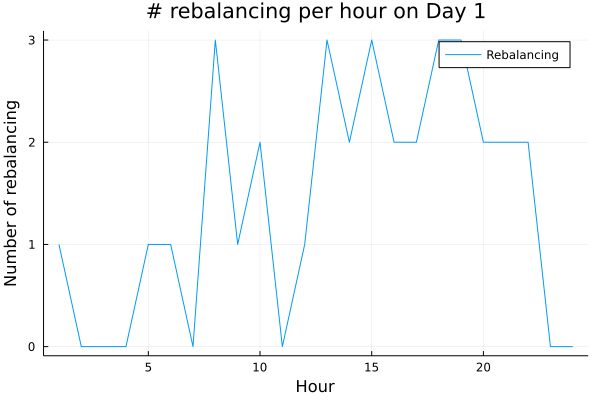

In [288]:
using Plots
plot([sum(x_1[:,:,:,i]) for i=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancing per hour on Day 1")

In [289]:
res_1=export_results(z_1)
using Tables
# convert array to csv file
CSV.write("../results/results_day1.csv", Tables.table(res_1))
# export demand day 1
jldsave("../results/demand_day1.jld2", true; d_new)

In [297]:
res_1

34×5 Matrix{Float64}:
  2.0  20.0  2.0   1.0   8.0
 28.0  34.0  3.0   5.0   6.0
 19.0  39.0  1.0   6.0   5.0
 13.0  37.0  1.0   8.0   9.0
 49.0  26.0  2.0   8.0   8.0
 16.0   4.0  3.0   8.0   5.0
  2.0  30.0  3.0   9.0  10.0
 49.0  12.0  1.0  10.0   9.0
 15.0  17.0  3.0  10.0   6.0
 37.0  13.0  1.0  12.0  10.0
  7.0  21.0  1.0  13.0   7.0
 20.0   2.0  2.0  13.0   5.0
 30.0   2.0  3.0  13.0   9.0
  ⋮                     
  4.0  16.0  1.0  18.0   9.0
 19.0  39.0  2.0  18.0   6.0
  3.0  25.0  3.0  18.0  10.0
  5.0   4.0  1.0  19.0  10.0
 16.0   4.0  2.0  19.0   8.0
 16.0   4.0  3.0  19.0  10.0
 27.0  18.0  2.0  20.0   7.0
  4.0   5.0  3.0  20.0  10.0
 30.0   2.0  1.0  21.0  10.0
 20.0   2.0  2.0  21.0  10.0
  2.0  20.0  1.0  22.0   6.0
 37.0   9.0  2.0  22.0   9.0

In [290]:
#print_results(res_1)

## Solve for Day 8

In [291]:
x_2,w_2,u_2,y_2,z_2,obj_2=solve_model(K,S,C_new,D_new,X_new,y0_new,d_2_new,lambda,n_rebal);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 100
Objective value: 1267.9000444622236


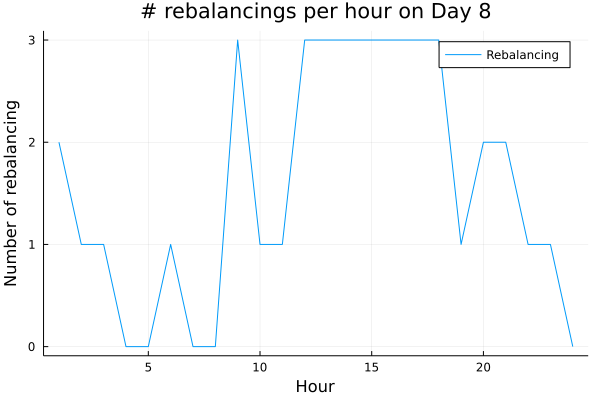

In [292]:
using Plots
plot([sum(x_2[:,:,:,i]) for i=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancings per hour on Day 8")

In [293]:
res_2=export_results(z_2)

38×5 Matrix{Float64}:
  4.0  16.0  2.0   1.0   5.0
 25.0  43.0  3.0   1.0   5.0
  9.0  10.0  1.0   2.0   5.0
 28.0  40.0  1.0   3.0   3.0
  1.0  50.0  2.0   6.0   6.0
 17.0  15.0  1.0   9.0   9.0
 28.0  40.0  2.0   9.0  10.0
 16.0  14.0  3.0   9.0   8.0
 41.0  19.0  2.0  10.0   7.0
  3.0  44.0  3.0  11.0   6.0
  2.0  20.0  1.0  12.0  10.0
  2.0  30.0  2.0  12.0  10.0
  3.0  44.0  3.0  12.0  10.0
  ⋮                     
  9.0  13.0  2.0  17.0  10.0
  8.0  35.0  3.0  17.0  10.0
 13.0  37.0  1.0  18.0   8.0
  7.0  21.0  2.0  18.0  10.0
 30.0  20.0  3.0  18.0   7.0
  4.0   5.0  3.0  19.0   5.0
  2.0   6.0  1.0  20.0  10.0
  3.0  13.0  2.0  20.0  10.0
 13.0   3.0  1.0  21.0   7.0
 40.0  28.0  2.0  21.0   5.0
  4.0  16.0  1.0  22.0   5.0
 11.0  42.0  2.0  23.0  10.0

## Solve for Day 15

In [294]:
x_3,w_3,u_3,y_3,z_3,obj_3=solve_model(K,S,C_new,D_new,X_new,y0_new,d_3_new,lambda,n_rebal);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 100
Objective value: 1572.7418991707546


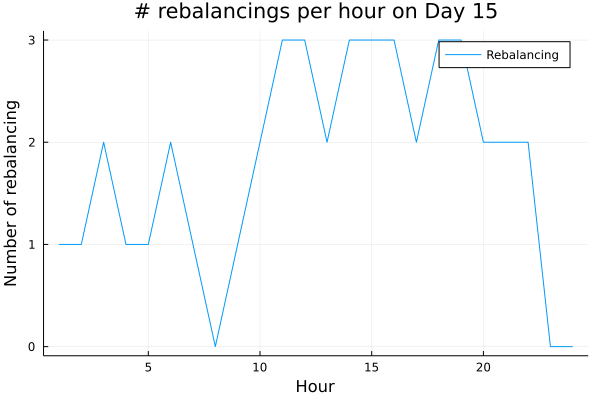

In [295]:
using Plots
plot([sum(x_3[:,:,:,i]) for i=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancings per hour on Day 15")

In [296]:
res_3=export_results(z_3)

43×5 Matrix{Float64}:
 12.0  49.0  3.0   1.0   9.0
 28.0  34.0  3.0   2.0   9.0
  9.0  10.0  2.0   3.0  10.0
  4.0   5.0  3.0   3.0   6.0
  6.0  43.0  1.0   4.0  10.0
  8.0  35.0  1.0   5.0   8.0
  1.0   9.0  2.0   6.0   7.0
  3.0  44.0  3.0   6.0   8.0
  7.0  21.0  1.0   7.0   9.0
 20.0   6.0  2.0   9.0  10.0
 30.0   6.0  1.0  10.0  10.0
 27.0  18.0  2.0  10.0   5.0
  4.0  16.0  1.0  11.0  10.0
  ⋮                     
  4.0   5.0  1.0  18.0  10.0
  4.0   5.0  2.0  18.0  10.0
 37.0  13.0  3.0  18.0   8.0
  3.0  37.0  1.0  19.0   8.0
 17.0  15.0  2.0  19.0  10.0
 16.0   4.0  3.0  19.0   8.0
 35.0   8.0  1.0  20.0  10.0
  3.0  25.0  2.0  20.0   9.0
 19.0  39.0  1.0  21.0   1.0
  9.0   1.0  2.0  21.0  10.0
 25.0   3.0  1.0  22.0  10.0
 13.0   3.0  3.0  22.0   5.0

## Dummy data

In [17]:
# capacity of stations
C = [10,10,10,10];

# d of stations
d = [[[0,10,0,5] [0,0,0,0] [0,5,0,0] [20,0,0,0]];;;
    [[0,0,0,0] [0,0,0,0] [30,0,0,0] [0,10,0,0]];;;
    [[0,0,0,5] [0,0,15,0] [0,0,0,0] [0,0,0,0]]];

# proximity of stations
X = [[0,1,1,1] [1,0,1,1] [1,1,0,1] [1,1,1,0]];

# capacity of stations
y0 = [6,2,4,3];

# number of vans
K = 2;

# capacity of vans
S = 20;

# distance of stations
D = [[0,0.5,1,0.5] [2,0,0.5,1] [0.5,1,0,0.5] [1,2,1,0]];

# number of stations
n_stations = 4;
n_hours=3;